In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg

In [3]:
DATASET_PATH = "../fashion-images-small/"
print(os.listdir(DATASET_PATH))

['images', 'myntradataset', 'styles.csv']


In [4]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=15000, on_bad_lines="skip")
#df = pd.read_csv(DATASET_PATH + "styles.csv", on_bad_lines="skip")
print(df.shape)
df.head()

(15000, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [5]:
%%time
import os

def get_all_filenames(directory):
    """
    Returns a set of all filenames in the given directory.
    """
    filenames = {entry.name for entry in os.scandir(directory) if entry.is_file()}
    return filenames

images = get_all_filenames(DATASET_PATH + "images/")

CPU times: total: 0 ns
Wall time: 31.2 ms


In [6]:
def check_image_exists(image_filename):
    """
    Checks if the desired filename exists within the filenames found in the given directory.
    Returns True if the filename exists, False otherwise.
    """
    global images
    if image_filename in images:
        return image_filename
    else:
        return np.nan

df['image'] = df["id"].apply(lambda imageID: check_image_exists(str(imageID) + ".jpg"))
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [7]:
df.isna().sum() # Check for missing values

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour              4
season                  6
year                    0
usage                 101
productDisplayName      2
image                   1
dtype: int64

In [8]:
df = df.dropna(subset=['image'])
df.shape

(14999, 11)

In [9]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img,display=False):
    if display :
        return DATASET_PATH+"/images/"+img
    else :
        return DATASET_PATH+"/images/"+img

def load_image(img,display=False):
    return cv2.imread(img_path(img,display))

<Axes: ylabel='articleType'>

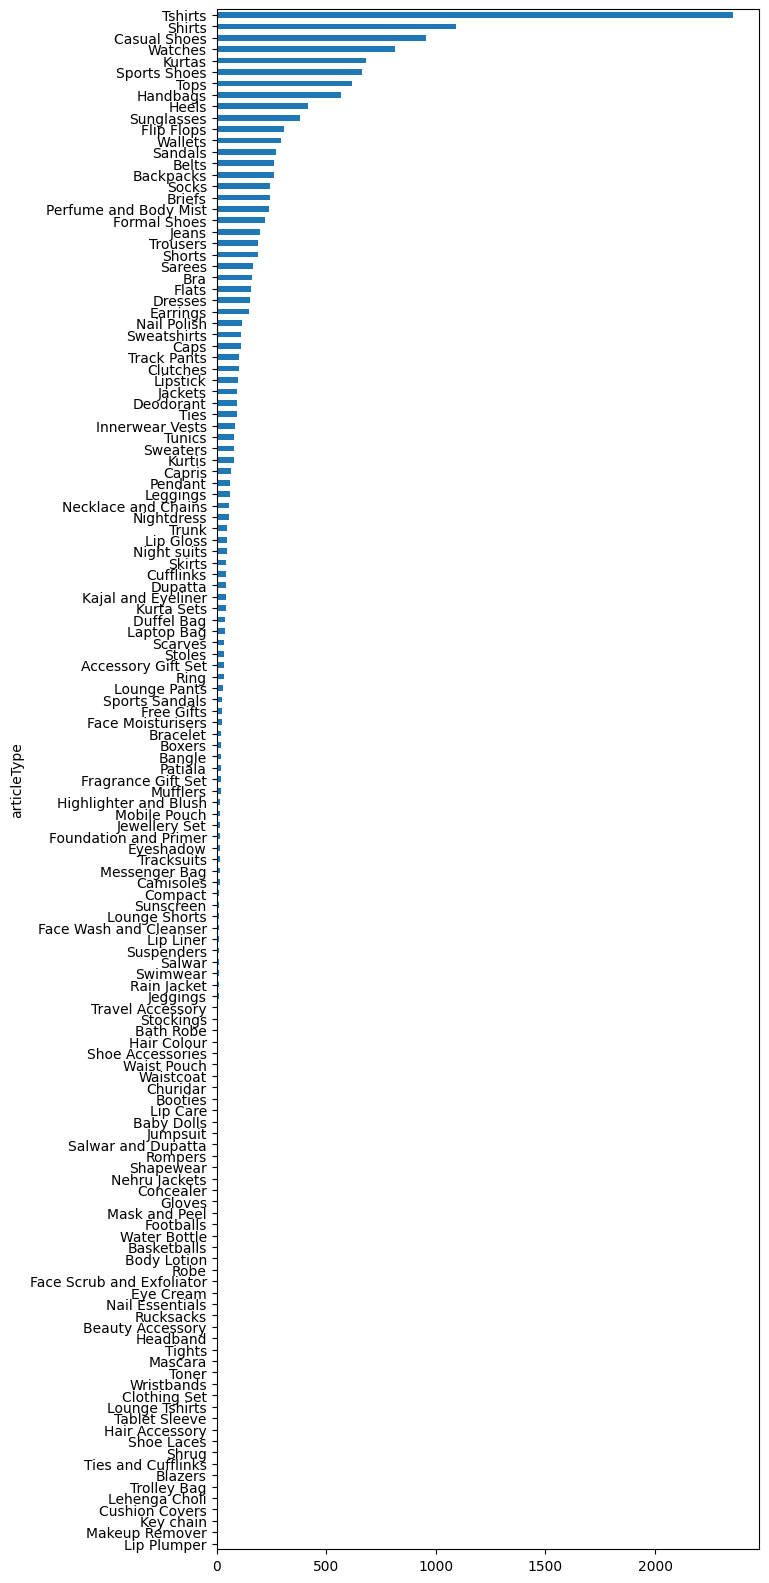

In [10]:
# Plotting the distribution of the articleType
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [11]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__

'2.16.1'

In [12]:
# Input Shape
img_width, img_height, _ = load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
i = 0
import time
start_time = time.time()
def get_embedding(model, img_name):
    global i, start_time
    if((i < 1000 and i%50 == 0) or i%200 == 0):
        print(i, "Time elapsed so far: {:.2f} minutes".format((time.time() - start_time) / 60))
    i += 1
    
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x,verbose=0).reshape(-1)

In [14]:
emb = get_embedding(model, df.iloc[59].image)
emb.shape

0 Time elapsed so far: 0.00 minutes


(2048,)

[0.49842674 4.9910502  0.         ... 2.835724   4.693336   0.        ]


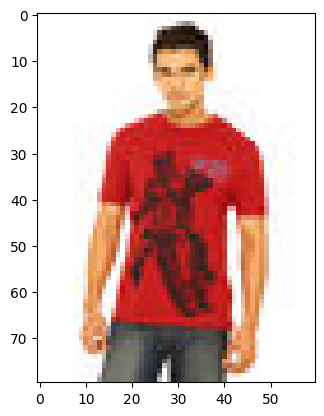

In [15]:
plt.imshow(cv2.cvtColor(load_image(df.iloc[59].image,True), cv2.COLOR_BGR2RGB))
print(emb)

In [16]:
import dask.dataframe as dd

# Create a Dask dataframe from your Pandas dataframe
dask_df = dd.from_pandas(df, npartitions=32)

# Define the expected output type of your function
meta = pd.Series([], dtype=float)

In [17]:
%%time
import time
start_time = time.time()
i = 0

# Apply the function to each partition of the dataframe in parallel
dask_result = dask_df['image'].map(lambda img: get_embedding(model, img), meta=meta)

# Compute the result
result = dask_result.compute().reset_index(drop=True)

0 Time elapsed so far: 0.02 minutes
50 Time elapsed so far: 0.04 minutes
100 Time elapsed so far: 0.07 minutes
150 Time elapsed so far: 0.10 minutes
200 Time elapsed so far: 0.12 minutes
250 Time elapsed so far: 0.14 minutes
300 Time elapsed so far: 0.17 minutes
350 Time elapsed so far: 0.20 minutes
400 Time elapsed so far: 0.22 minutes
450 Time elapsed so far: 0.25 minutes
500 Time elapsed so far: 0.28 minutes
550 Time elapsed so far: 0.30 minutes
600 Time elapsed so far: 0.32 minutes
650 Time elapsed so far: 0.35 minutes
700 Time elapsed so far: 0.38 minutes
750 Time elapsed so far: 0.42 minutes
800 Time elapsed so far: 0.46 minutes
850850 Time elapsed so far: 0.51 minutes
 Time elapsed so far: 0.51 minutes
900 Time elapsed so far: 0.56 minutes
950 Time elapsed so far: 0.61 minutes
1000 Time elapsed so far: 0.66 minutes
1200 Time elapsed so far: 0.86 minutes
1400 Time elapsed so far: 1.06 minutes
1600 Time elapsed so far: 1.19 minutes
1800 Time elapsed so far: 1.33 minutes
2000 Time 

In [18]:
print(result.shape)
result.head()

(14999,)


0    [0.0, 3.6514258, 0.0, 0.7522205, 0.0, 0.0, 4.1...
1    [1.8793409, 1.600873, 0.09203231, 4.4330616, 0...
2    [0.0, 0.31118727, 0.0, 3.8086739, 0.4370345, 7...
3    [0.58801913, 9.894608, 0.0, 6.2953224, 1.78372...
4    [0.0, 1.8829622, 0.0, 5.1220965, 0.0, 0.0, 2.9...
Name: image, dtype: object

In [19]:
df_embds = result.apply(pd.Series)

In [20]:
print(df_embds.shape)
df_embds.head()

(14999, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,3.651426,0.000000,0.752221,0.000000,0.000000,4.103798,2.382156,2.472525,0.0,...,0.366392,0.000000,0.000000,6.000703,0.000000,0.000000,6.389924,4.246396,1.067712,1.671664
1,1.879341,1.600873,0.092032,4.433062,0.000000,0.000000,3.030763,8.530570,5.498654,0.0,...,2.808280,0.000000,3.923485,3.183103,0.000000,0.000000,4.244201,3.268904,2.271731,5.433407
2,0.000000,0.311187,0.000000,3.808674,0.437034,7.112511,0.000000,0.000000,0.000000,0.0,...,0.218199,7.861313,1.655936,0.000000,0.000000,0.000000,4.703001,0.000000,2.340576,0.000000
3,0.588019,9.894608,0.000000,6.295322,1.783728,1.913131,0.000000,13.309915,7.805776,0.0,...,22.434389,0.000000,0.000000,0.000000,2.565922,3.330475,0.594377,1.130442,3.084234,7.608923
4,0.000000,1.882962,0.000000,5.122097,0.000000,0.000000,2.950300,6.626856,1.606640,0.0,...,2.504940,0.000000,1.274126,3.484577,0.786343,0.000000,1.597860,2.515503,0.068357,0.000000


In [21]:
from scipy import sparse

# df_embds.to_csv("df_embds_img.csv",index=False)
# Convert DataFrame to a sparse matrix


sparse_matrix = sparse.csr_matrix(df_embds.values)

# Save the sparse matrix to a file
sparse.save_npz('../data/sparse_matrix_df_embds_img.npz', sparse_matrix)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate the text columns into a single column
df['combined_text'] = [' '.join(row) for row in df[['gender', 'masterCategory', 'subCategory', 'articleType',
                                                     'baseColour', 'season', 'year', 'usage',
                                                     'productDisplayName']].values.astype(str)]


# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the combined_text column
tfidf_embeddings = vectorizer.fit_transform(df['combined_text'])

# tfidf_embeddings is a sparse matrix containing the TF-IDF vectors
tfidf_embeddings

<14999x5074 sparse matrix of type '<class 'numpy.float64'>'
	with 169210 stored elements in Compressed Sparse Row format>

In [25]:
from scipy import sparse

# Save the sparse matrix to a file
sparse.save_npz('../data/sparse_matrix_df_embds_tfidf.npz', tfidf_embeddings)

In [26]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim_imgs = 1-pairwise_distances(df_embds, metric='cosine')
cosine_sim_imgs[:4, :4]

array([[1.        , 0.578943  , 0.23815554, 0.49101055],
       [0.578943  , 0.99999946, 0.23951328, 0.7227352 ],
       [0.23815554, 0.23951328, 1.        , 0.22011638],
       [0.49101055, 0.7227352 , 0.22011638, 1.        ]], dtype=float32)

In [27]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim_tfidf = 1-pairwise_distances(tfidf_embeddings, metric='cosine')
cosine_sim_tfidf[:4, :4]

array([[1.        , 0.18218686, 0.00698982, 0.08623057],
       [0.18218686, 1.        , 0.00593168, 0.08422119],
       [0.00698982, 0.00593168, 1.        , 0.00504161],
       [0.08623057, 0.08422119, 0.00504161, 1.        ]])

In [28]:
indices = pd.Series(range(len(df)), index=df.index)
indices.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [38]:
cosine_sim = cosine_sim_tfidf * 0.35 + cosine_sim_imgs * 0.65
print(cosine_sim.shape)
cosine_sim[:4,:4]

(14999, 14999)


array([[0.99999998, 0.44007834, 0.15724754, 0.34933756],
       [0.44007834, 0.99999962, 0.15775971, 0.4992553 ],
       [0.15724754, 0.15775971, 0.99999998, 0.14484021],
       [0.34933756, 0.4992553 , 0.14484021, 0.99999998]])

In [39]:
# Function that get image recommendations based on the cosine similarity score of other images
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

In [30]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [31]:
%%time
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embds)

c:\Users\Ayadi Nassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


CPU times: total: 1min 15s
Wall time: 55.5 s


c:\Users\Ayadi Nassim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

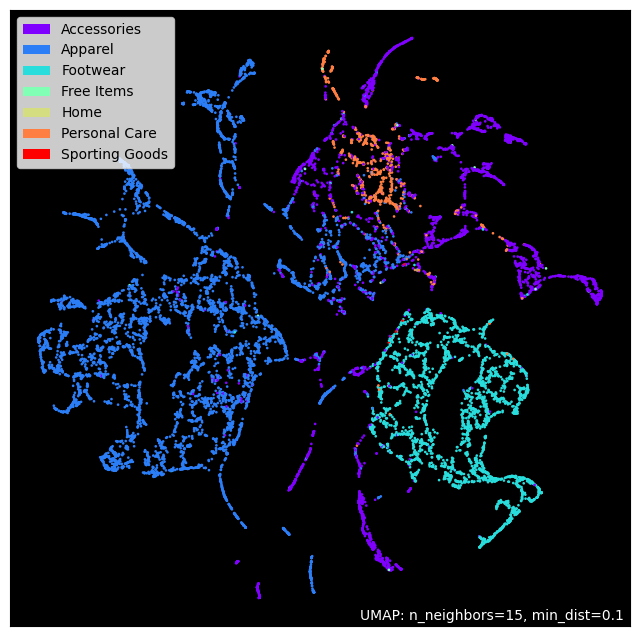

In [32]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
import umap.plot
mapper_org = umap.UMAP().fit(tsne_results)
umap.plot.points(mapper_org, labels=df["masterCategory"], theme='fire')

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

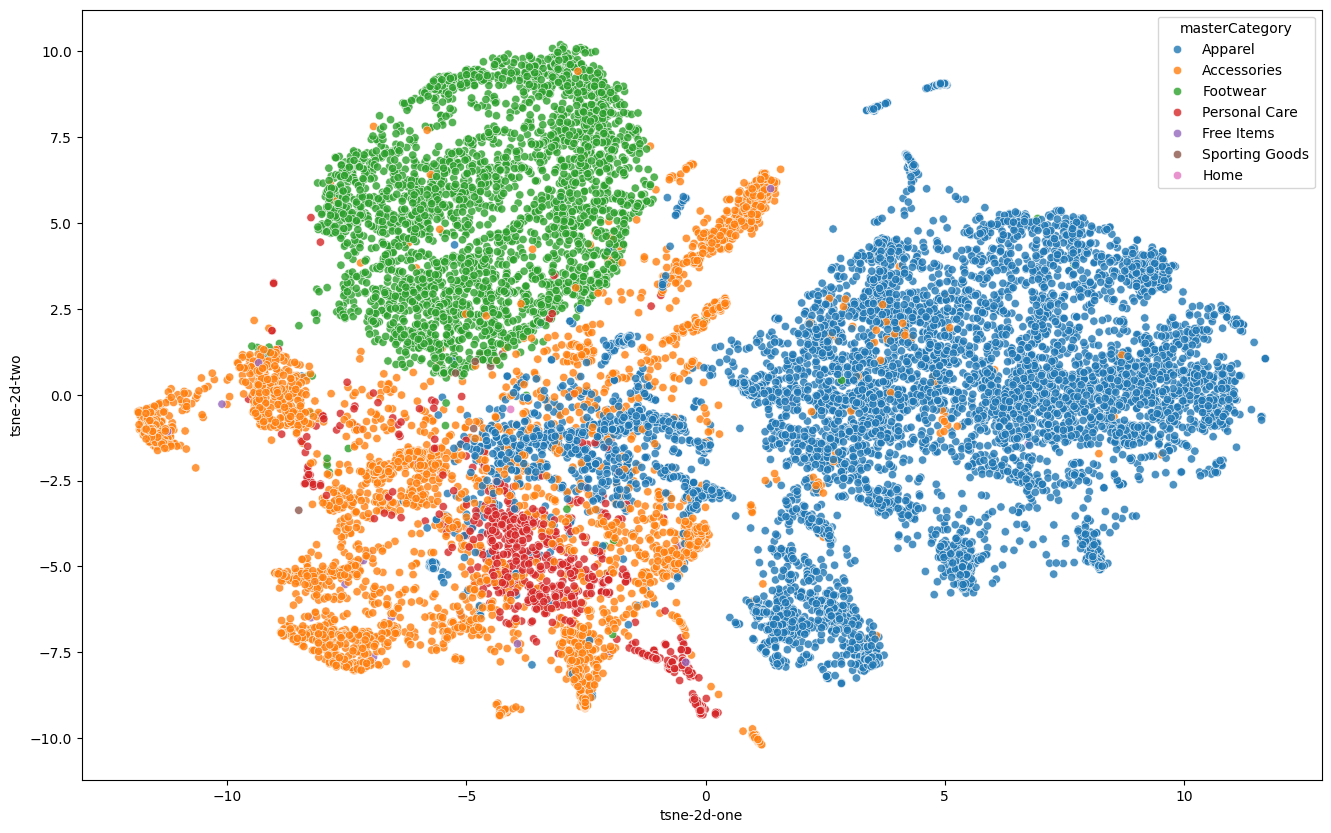

In [33]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

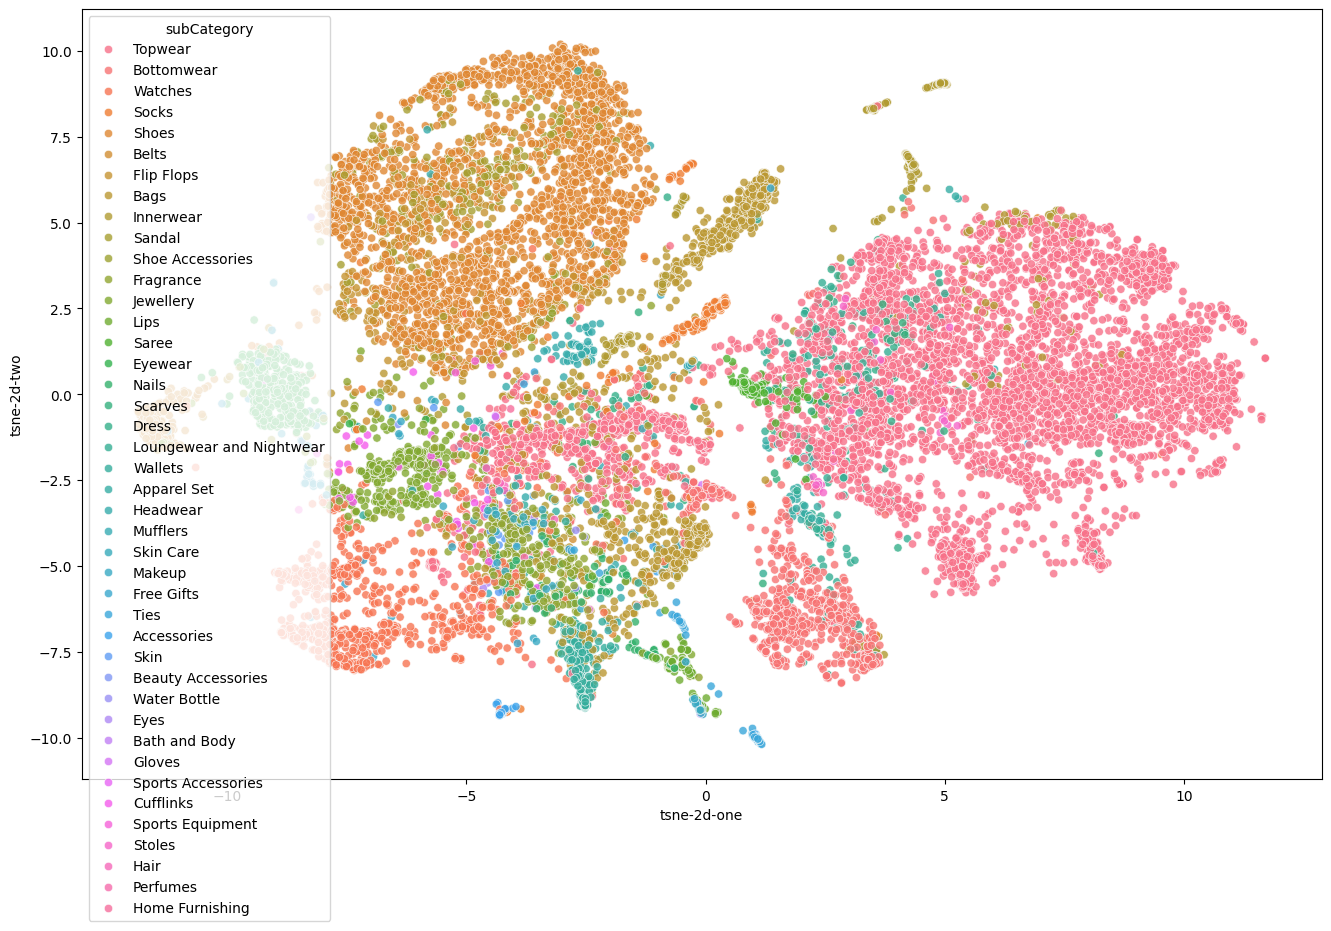

In [34]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

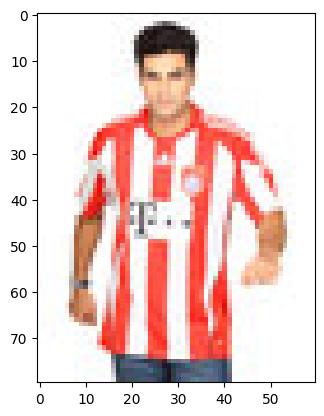

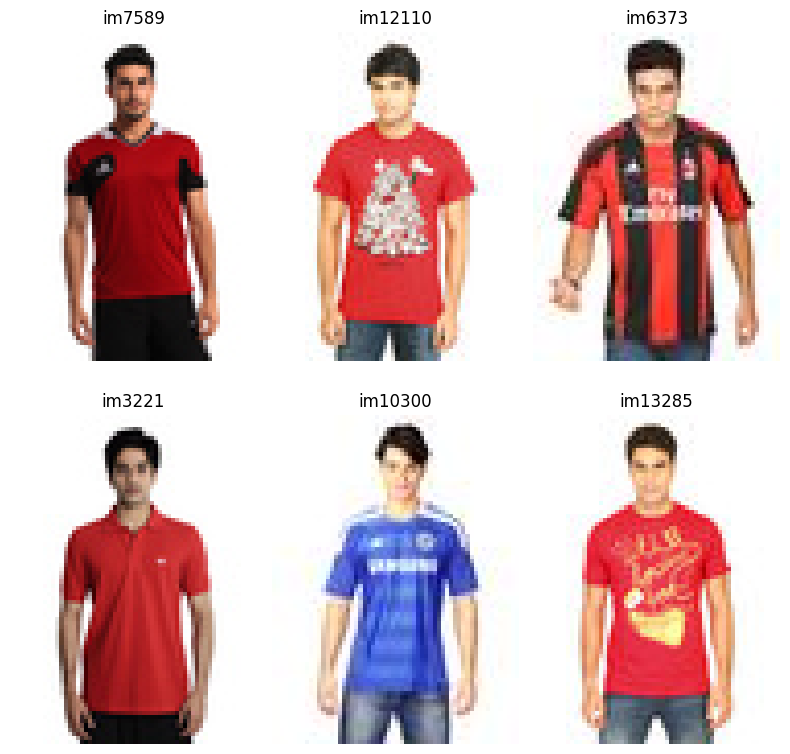

In [40]:
# Idx Item to Recommender
idx_ref = 697

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image,True), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image,True) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)